# A neural network model for regression problems

We will see here how to use Keras to implement a simple neural network model for a **regression problem** (continuous target variable). 
For this practical session we are using the [Boston house princing dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), exploring the relationship between house prices (in thousands of dollars) and a series of thirteen numerical properties of houses in Boston suburbs.

Fortunately for us, is a very well known dataset, handily included in the [sklearn library](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html).

# The usual seed priming

In [ ]:
#general random seed
from numpy.random import seed
seed(10)

#tensorflow-specific seed. If you want to know why
#we need to set two separate random seeds see
#https://blog.cmgresearch.com/2020/09/04/tensorflow-has-to-random-seeds.html
import tensorflow
tensorflow.random.set_seed(10)

# Loading libraries and getting the data

We first load some necessary libraries and get the data from the `github` repository

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt

(features, target_variable) = datasets.load_boston(return_X_y=True)

#for data description and manipulation a pandas dataframe is handier
#than a numpy matrix. Moreover, you can always go back using .to_numpy()
#method
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_numpy.html
features = pd.DataFrame(features)

# Data description

In [ ]:
#taking a look at the features
features.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


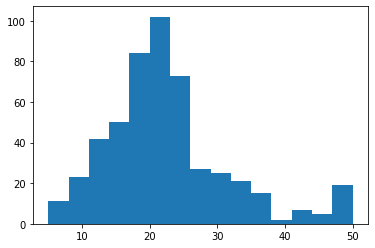

In [ ]:
#taking a look at the target variable
plt.hist(target_variable, bins = 15)
plt.show()

# Data preprocessing

## Missing values removal

It's always useful to check if something is missing, since usually regression models don't like missing values.

In [ ]:
features.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

No values are missing, but just in case the code belows takes care of holes in the features data frame.

In [ ]:
#fast way, but only for one data frame...
#features = features.dropna()

#finding features with at least one missing data point
missing = features.isnull().sum(axis = 1) > 0

#you cannot simply use the "not" operator on a series
#it's ambigous. We need to pass through a proper
#negation function from numpy
not_missing = np.logical_not(missing)

#subsetting
features = features.loc[not_missing, :]
target_variable = target_variable[not_missing]

#just checking
print("Size of target variable: ", target_variable.shape)
print("Size of feature matrix: ", features.shape)

Size of target variable:  (506,)
Size of feature matrix:  (506, 13)


## Discussion: what if we are missing target values?

The code above shows us how to remove samples with missing values in the `features` data frame. What if we have missing values in the target array?

Pay attention: `target_variable` is a NumPy array. What kind of data should we expect?

## Discussion: outliers removal?

Should we remove outliers data? If yes, do it in the space below. If no, tell us why.

In [ ]:
######## YOUR CODE HERE ########
if False:
  #some very refined logic...
  outlier = target_variable > 40

  #subsetting
  features = features.loc[np.logical_not(outlier), :]
  target_variable = target_variable[np.logical_not(outlier)]

  #just checking
  print("Size of target variable: ", target_variable.shape)
  print("Size of feature matrix: ", features.shape)
################################

## Discussion/Exercise: data normalization?

Should we normalize the features? If yes, do it in the space below. If no, tell us why.

In [ ]:
######## YOUR CODE HERE ########
if True:
  #getting mean and standard deviation for train set
  avg = features.mean()
  std = features.std()

  #normalizing
  features = (features - avg)/std

  #checking if we are doing everything fine
  print(pd.DataFrame(features).describe())
################################

                 0             1   ...            11            12
count  5.060000e+02  5.060000e+02  ...  5.060000e+02  5.060000e+02
mean   8.326673e-17  3.466704e-16  ...  8.117354e-15 -6.494585e-16
std    1.000000e+00  1.000000e+00  ...  1.000000e+00  1.000000e+00
min   -4.193669e-01 -4.872402e-01  ... -3.903331e+00 -1.529613e+00
25%   -4.105633e-01 -4.872402e-01  ...  2.048688e-01 -7.986296e-01
50%   -3.902803e-01 -4.872402e-01  ...  3.808097e-01 -1.810744e-01
75%    7.389247e-03  4.872402e-02  ...  4.332223e-01  6.024226e-01
max    9.924110e+00  3.800473e+00  ...  4.406159e-01  3.545262e+00

[8 rows x 13 columns]


# Training and validation sets

We have a resonable-sized dataset, we can go with one of the standard split-validation cuts, e.g. 10% 

> **[PRO TIP]** In very small dataset you may be forced to do "leave one out" crossvalidation. For N samples you cycle selecting one sample for predictions (this would be your validation set) and keeping N-1 for training. Unfortunately in this case you cannot compute correlations (can you guess why?) and must use error-related metrics like Mean Squared Error.




In [ ]:
#we import a function to perform the split
from sklearn.model_selection import train_test_split

features_train, features_val, target_train, target_val = train_test_split(features, target_variable, test_size=0.10)
    
#let's print some shapes to get an idea of the resulting data structure
print(features_train.shape)
print(features_val.shape)
print(target_train.shape)
print(target_val.shape)

(455, 13)
(51, 13)
(455,)
(51,)


# Building the neural networks model

We are now ready to build our neural networks model for regression. First, we set some hyperparameters:

- the activation function in the output layer in this case is **linear**: we get directly the results from $\sum wx + b$ 
- the loss function is MSE (**Mean Squared Error**)

In [ ]:
# Configuration options

#Keras wants the data shape as a tuple. In case of images is something 
#like (image width, image height, number of channels). 
#In our case data is tabular so each data point is an 
#array (a row in the table) and we just need to specify 
#a single number, i.e. the number of columns. However, we still need
#to input a tuple, so...
input_shape = (features.shape[1],) 

#other standard features describing our network
hidden_nodes = 16
hidden_activation = 'relu'
output_activation = 'linear'
loss_function = 'mean_squared_error'
optimizer_used = 'rmsprop'
num_epochs = 10

In [ ]:
print(input_shape)

(13,)


As we learnt to do throughout the course, we now use `keras` to build our sequential neural networks model:

In [ ]:
#we are building a "sequential" model, meaning that the data will 
#flow like INPUT -> ELABORATION -> OUTPUT.
from keras.models import Sequential

#a "dense" layer is a layer were all the data coming in are connected
#to all nodes.
from keras.layers import Dense

#adding the hidden layer with the required number of nodes, plus the final
#layer with a single node (since we want to output a single number)
model = Sequential()
model.add(Dense(units=hidden_nodes, input_shape=input_shape, activation=hidden_activation))
model.add(Dense(1, activation=output_activation))

#the model is declared, but we still need to compile it to actually
#build all the data structures
model.compile(optimizer=optimizer_used, loss=loss_function)

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________
None


The `model.summary()` tells us that we now have 145 model parameters to learn: 

- hidden layer: 7 feature weights x 16 units + 16 bias terms $\rightarrow$ 128 parameters
- output layer: 16 unit weights + 1 bias term $\rightarrow$ 17 parameters  
- 128 + 17 = 145 parameters

# Training the neural network model

In [ ]:
num_epochs = 100
history = model.fit(
    features_train, target_train, 
    epochs=num_epochs, validation_data=(features_val, target_val), verbose = 0)

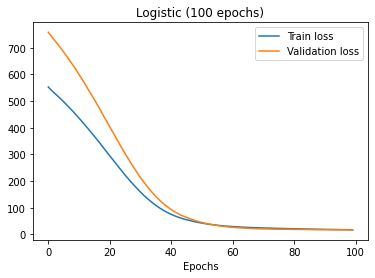

In [ ]:
def plot_loss_history(h, title):
    plt.plot(h.history['loss'], label = "Train loss")
    plt.plot(h.history['val_loss'], label = "Validation loss")
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()
    plt.show()

plot_loss_history(history, 'Logistic ({} epochs)'.format(num_epochs))

# Predictions

We can now see the predictions our neural networks model produced for the house prices. Below we report also the known target values from the test set 

In [ ]:
#predicting, and reporting the shape of the obtained object (also known as y hat)
predictions = model.predict(features_val)
print(predictions.shape)

(51, 1)


In [ ]:
#a couple of print on true target values (also known as y)
print(target_val)
print(target_val.shape)

[28.4 31.1 23.5 26.6 19.6 14.3 50.  14.3 20.7 37.6 20.4 27.5 36.2 32.
 33.1 48.8 24.6 26.4 23.2 17.  41.3 14.9 18.5 25.  36.4 19.5 27.1 14.9
 46.  17.9 30.3 31.6 23.1 24.7 16.7 18.3  8.4 37.3 22.1 22.  46.7 30.1
 12.1 29.1 16.6 23.9 19.9 21.4 45.4 15.6 22.7]
(51,)


In regression problems you can not use the same accuracy metrics as in classification problems (e.g. error rate, confusion matrix, etc.): in stead, other metrics are used like:

- **Pearson linear correlation**
- **Spearman rank correlation**
- **RMSE** (root mean squared error)
- **MAE** (mean absolute error)
- etc. (there are many more)

In [ ]:
#changing forma to pandas Series, for handiness
y_pred = pd.Series(predictions[:,0])
y = pd.Series(target_val)

#computing correlation
accuracy = y.corr(y_pred, method='pearson')
print("accuracy (measured as Pearson's correlation) is: ", accuracy)

accuracy (measured as Pearson's correlation) is:  0.9144658450895198



A scatter plot of predicted vs true values can also be useful to visualise the result of the model:



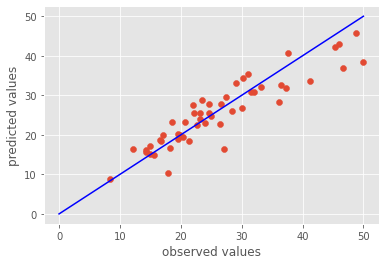

In [ ]:
plt.style.use('ggplot')

plt.scatter(y, y_pred)
#equivalent: plt.plot(y, y_pred, "o")

# draw the main diagonal, for reference
plt.plot([0, 50], [0, 50], color='b')

#labelling the axis
plt.xlabel("observed values")
plt.ylabel("predicted values")

plt.show()

In [ ]:
#Root Mean Square Error
print('Root Mean Square Error : ' + str(np.sqrt(sum((y-y_pred)**2)/len(y))))
print('Target mean            : ' + str(y.mean()))
print('Predictions mean       : ' + str(y_pred.mean()))

Root Mean Square Error : 4.115160645432852
Target mean            : 26.172549019607843
Predictions mean       : 25.631776809692383


# Exercise: improve the network

The predictions are not terrible but for sure not excellent. How to improve the performances?

# Extra: first layer weights

Explore the weights the network assigns to the first layer, and try to understand if it implements some kind of feature selection.

Remember: our network has 16 nodes in the first layer, and 13 input features.

In [ ]:
#extracting weights and biases
first_layer_weights = model.layers[0].get_weights()[0]
first_layer_biases = model.layers[0].get_weights()[1]

In [ ]:
#taking a look at the shape of the weights matrix
print(first_layer_weights.shape)

(13, 16)


In [ ]:
#IMPORTANT we are interested in absolute values of the weights
#since a -15 is way more important than a +0.1
first_layer_weights = np.absolute(first_layer_weights) 

In [ ]:
#It's handy to have a pandas dataframe for data exploration and 
#description
w = pd.DataFrame(first_layer_weights)

#it's also better to have features as columns and
#nodes as rows, since many statistics are available out of the
#box on a by-column basis
w = w.transpose()

In [ ]:
#taking a look at the raw weights
print(w)

          0         1         2   ...        10        11        12
0   0.799892  0.265596  0.233227  ...  0.924435  0.294333  0.158073
1   0.162244  1.275239  0.779537  ...  0.466767  0.607485  0.051039
2   0.632052  0.167374  0.220075  ...  0.120854  0.033961  0.603665
3   0.162838  0.150600  0.394560  ...  0.422450  0.538558  1.149420
4   0.483702  0.393508  0.369496  ...  0.764609  0.165547  0.588818
5   0.288023  0.622720  0.784089  ...  0.027848  0.321956  0.268315
6   0.502131  0.477210  0.302369  ...  0.514626  0.164271  0.432964
7   1.327950  0.287902  0.324533  ...  0.834971  0.953587  0.364946
8   0.367334  0.119785  0.225622  ...  0.143470  0.086861  0.604454
9   0.090558  1.200999  0.919577  ...  0.483234  0.248139  0.255336
10  1.348775  0.137326  1.124533  ...  0.306856  0.706804  0.017343
11  0.512942  0.072570  0.349062  ...  0.156922  0.152195  0.639788
12  0.983900  1.329018  0.116792  ...  0.032418  0.577915  0.871716
13  1.304445  0.131519  0.251647  ...  0.297089 

In [ ]:
#summary statistics
w.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.664321,0.439140,0.427268,0.193738,0.362388,0.519126,0.372075,0.386439,0.475303,0.486324,0.368904,0.392544,0.452499
std,0.446123,0.437043,0.300406,0.235055,0.194498,0.394957,0.294482,0.350463,0.330947,0.346332,0.285868,0.308098,0.305181
min,0.090558,0.072570,0.116792,0.016587,0.020108,0.001273,0.041395,0.013772,0.006793,0.025098,0.027848,0.033961,0.017343
25%,0.347506,0.137077,0.231326,0.029495,0.218630,0.248065,0.152120,0.148201,0.254437,0.215960,0.137816,0.164645,0.231021
50%,0.507537,0.262065,0.313451,0.068502,0.399445,0.457182,0.239517,0.289765,0.465258,0.478176,0.330512,0.271236,0.466890
75%,1.049566,0.513588,0.490804,0.280291,0.533259,0.798773,0.656367,0.533666,0.583462,0.678623,0.491082,0.585307,0.603862
max,1.348775,1.329018,1.124533,0.708680,0.586358,1.224366,0.935506,1.148860,1.124871,1.079295,0.924435,1.033926,1.149420


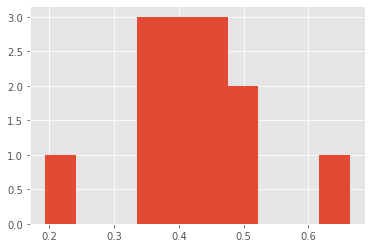

In [ ]:
plt.hist(w.mean())
plt.show()

Plotting the weights

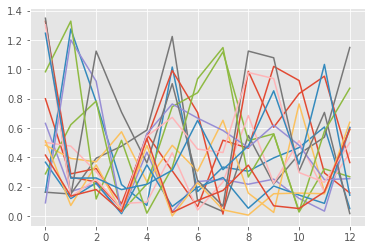

In [ ]:
#looping over nodes, adding one line at a time
for n in range(w.shape[0]):
  plt.plot(w.iloc[n, :], label = "node " + str(n))

#showing the plot
plt.show()